In [1]:
import pybiopax
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from collections import Counter
from ontobio.rdfgen.gocamgen.subgraphs import AnnotationSubgraph
import pprint
from base import relations


In [2]:
biopax_file = './resources/test_biopax/R-HSA-204174_level3.owl'
model = pybiopax.model_from_owl_file(biopax_file, encoding="utf8")

Processing OWL elements:   0%|          | 0.00/423 [00:00<?, ?it/s]

In [3]:
stats = Counter([obj.__class__.__name__  for uid, obj in model.objects.items()]).most_common(100)
stats

[('UnificationXref', 160),
 ('Stoichiometry', 37),
 ('SequenceSite', 34),
 ('RelationshipXref', 25),
 ('PublicationXref', 24),
 ('Protein', 18),
 ('ProteinReference', 16),
 ('FragmentFeature', 16),
 ('SequenceInterval', 16),
 ('SmallMolecule', 15),
 ('SmallMoleculeReference', 15),
 ('Complex', 15),
 ('Control', 8),
 ('BiochemicalReaction', 4),
 ('RelationshipTypeVocabulary', 4),
 ('PathwayStep', 4),
 ('Catalysis', 3),
 ('CellularLocationVocabulary', 2),
 ('ModificationFeature', 2),
 ('Pathway', 1),
 ('Provenance', 1),
 ('BioSource', 1),
 ('SequenceModificationVocabulary', 1)]

In [ ]:
for protein in model.get_objects_by_type(pybiopax.biopax.Pathway):
  
    pprint.pp(protein.__dict__)
    break
   

{'GO:0010510-1': {},
 'GO:0019120-1': {'GO:0010510-1': {0: {'relation': 'BFO:0000050'}},
                  'GSTZ1 dimer dehalogenates DCA to glyoxylate-1': {0: {'relation': 'RO:0002333'}},
                  'H2O-1': {0: {'relation': 'RO:0002233'}},
                  'DCA-1': {0: {'relation': 'RO:0002233'}},
                  'glyoxylate-1': {0: {'relation': 'RO:0002234'}},
                  'HCl-1': {0: {'relation': 'RO:0002234'}}},
 'GSTZ1 dimer dehalogenates DCA to glyoxylate-1': {},
 'H2O-1': {},
 'DCA-1': {},
 'glyoxylate-1': {},
 'HCl-1': {},
 'GO:0004740-1': {'GO:0010510-1': {0: {'relation': 'BFO:0000050'}},
                  'PDK isoforms phosphorylate lipo-PDH-1': {0: {'relation': 'RO:0002333'}},
                  'ATP-1': {0: {'relation': 'RO:0002233'}},
                  'lipo-PDH-1': {0: {'relation': 'RO:0002233'}},
                  'ADP-1': {0: {'relation': 'RO:0002234'}},
                  'p-lipo-PDH-1': {0: {'relation': 'RO:0002234'}}},
 'PDK isoforms phosphorylate lipo

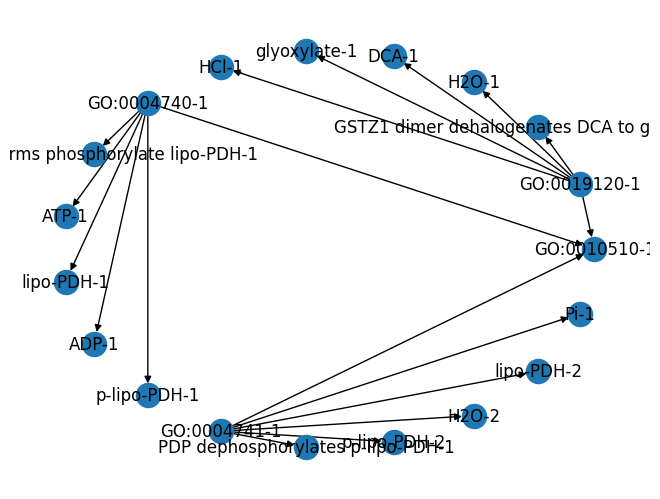

C:\Users\tmush\AppData\Local\Temp\ipykernel_28936\2157678240.py:86: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(gocam, prog="twopi")


ValueError: Node names and attributes should not contain ":" unless they are quoted with "".                For example the string 'attribute:data1' should be written as '"attribute:data1"'.                Please refer https://github.com/pydot/pydot/issues/258

In [13]:
class GoCAM (AnnotationSubgraph):
    def __init__(self):
        self.bp_node = None
        self.mf_map = {}
        super().__init__()

    def process_pathway(self, pathway):        
            
        if pathway.xref:
            self.process_bp(pathway.xref)

        if pathway.pathway_order:
            self.process_step_processes(pathway.pathway_order, pathway)
        
        if pathway.pathway_component:
            self.process_components(pathway.pathway_component, pathway)

    
    def process_step_processes(self, step_processes, pathway):
        for obj in step_processes:
            pc = model.objects[obj.uid]
            for sp in pc.step_process:
                if isinstance(sp, pybiopax.biopax.Catalysis) and sp.control_type == 'ACTIVATION':
                    self.process_mf(sp.xref, model.objects[sp.uid])
   
    
    def process_components(self, components, pathway):
        for obj in components:
            mf = self.mf_map.get(obj.uid, None)

            if mf is None:
                continue

            mf = self.add_instance_of_class(mf, is_anchor=True)

            if self.bp_node is not None:
                self.add_edge(mf, relations['part_of'], self.bp_node)

            gp = self.add_instance_of_class(obj.display_name)
            self.add_edge(mf, relations['enabled_by'], gp)

            pc = model.objects[obj.uid]

            if pc.left:
                self.process_mols(pc.left, relations['has_input'], mf)

            if pc.right:
                self.process_mols(pc.right, relations['has_output'], mf)
                
                                        
    def process_mf(self, xrefs, catalysis:pybiopax.biopax.Catalysis)    : 
        for xref in xrefs:
            if xref.db == 'GENE ONTOLOGY':
                self.mf_map[catalysis.controlled.uid] = xref.id
                
                
    def process_bp(self, xrefs): 
        for xref in xrefs:
            if xref.db == 'GENE ONTOLOGY':
                bp = self.add_instance_of_class(xref.id)
                self.bp_node = bp
                

    def process_mols(self, mols, relation, mf):
        for mol in mols:
            sm_node = self.add_instance_of_class(mol.display_name)
            self.add_edge(mf, relation, sm_node)
            
    
    def process_cc(self, xrefs): 
        pass
    
    
            
            
            
gocam = GoCAM()
for pathway in model.get_objects_by_type(pybiopax.biopax.Pathway):
    gocam.process_pathway(pathway)
pprint.pp(nx.to_dict_of_dicts(gocam))
print(gocam.mf_map)







In [ ]:
nx.draw(gocam, pos, with_labels=True)

plt.show()

pos = graphviz_layout(gocam, prog="twopi")
nx.draw(gocam, pos)
plt.show()

In [ ]:
%%timeit
gocam = AnnotationSubgraph()
for pathway in model.get_objects_by_type(pybiopax.biopax.Pathway):
    name = pathway
    mf_map = dict()
    bp_node = None
    print(name.uid)
    for xref in pathway.xref:
        print('\t %s ==> %s' % (xref.uid, xref.id))
        if(xref.db == 'GENE ONTOLOGY'):
            bp = gocam.add_instance_of_class(xref.id)
            bp_node = bp
        
    for obj in pathway.pathway_order:        
        pc = model.objects[obj.uid]   
        #pprint.pp(pc.__dict__)
        for sp in pc.step_process:            
            if isinstance (sp, pybiopax.biopax.Catalysis) and sp.control_type == 'ACTIVATION':
                catalysis = model.objects[sp.uid]     
                for xref in sp.xref:
                    if(xref.db == 'GENE ONTOLOGY'):
                        mf_map[catalysis.controlled.uid] = xref.id
                        
                        print('\t %s --> %s' % (xref.uid, xref.id))
        
    for obj in pathway.pathway_component:
        pprint.pp('%s ---> %s' % (obj.uid, obj.display_name))
        mf = mf_map.get(obj.uid, None)
        
        if mf == None:
            continue
        
        mf = gocam.add_instance_of_class(mf_map[obj.uid], is_anchor=True)
        
        if bp_node != None:
            gocam.add_edge(mf, relations['part_of'], bp_node)
            
        gp = gocam.add_instance_of_class(obj.display_name)
        gocam.add_edge(mf, relations['enabled_by'], gp)
        
        pc = model.objects[obj.uid]
                   
        for l in pc.left:
            sm = gocam.add_instance_of_class(l.display_name)
            gocam.add_edge(mf, relations['has_input'], sm)
            print('\t %s -> %s' % ('has_input',  l.display_name))
            
        for r in pc.right:
            sm = gocam.add_instance_of_class(r.display_name)
            gocam.add_edge(mf, relations['has_output'], sm)
            print('\t %s --> %s' % ('has_output',  r.display_name))
            
pprint.pp(nx.to_dict_of_dicts(gocam))

   

In [ ]:
gocam = AnnotationSubgraph()
for pathway in model.get_objects_by_type(pybiopax.biopax.Pathway):
    name = pathway
   
    print(name.uid)
    for obj in pathway.pathway_order:
        pc = model.objects[obj.uid]   
        for sp in pc.step_process:            
            if isinstance (sp, pybiopax.biopax.Catalysis) and sp.control_type == 'ACTIVATION':
                catalysis = model.objects[sp.uid]     
                for xref in sp.xref:
                    if(xref.db == 'GENE ONTOLOGY'):                        
                        print('\t %s: %s --> %s' % (catalysis.controlled.uid, 'MF', xref.id))
        
    for obj in pathway.pathway_component:
        pprint.pp('%s -> %s' % (obj.uid, obj.display_name))
        pc = model.objects[obj.uid]
                   
        for l in pc.left:
            print('\t %s -> %s' % ('has_input',  l.display_name))
            
        for r in pc.right:
            print('\t %s --> %s' % ('has_output',  r.display_name))
        
   